In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Loading the data

In [2]:
train_values = pd.read_csv("./data/train_values.csv")
train_labels = pd.read_csv("./data/train_labels.csv")
test_values = pd.read_csv("./data/test_values.csv")

# Pre-processing

In [3]:
train_data_raw = train_values.merge(train_labels, on="building_id")
test_data_raw = test_values

In [4]:
# Make a list of categorical columns
categorical_columns = []
for column in train_data_raw.columns:
    if train_data_raw[column].dtype == "object":
        categorical_columns.append(column)

assert len(categorical_columns) == 8
print(f"Categorical columns: {categorical_columns}")

# Make a list of binary columns
binary_columns = [
    "has_superstructure_adobe_mud",
    "has_superstructure_mud_mortar_stone",
    "has_superstructure_stone_flag",
    "has_superstructure_cement_mortar_stone",
    "has_superstructure_mud_mortar_brick",
    "has_superstructure_cement_mortar_brick",
    "has_superstructure_timber",
    "has_superstructure_bamboo",
    "has_superstructure_rc_non_engineered",
    "has_superstructure_rc_engineered",
    "has_superstructure_other",
    "has_secondary_use",
    "has_secondary_use_agriculture",
    "has_secondary_use_hotel",
    "has_secondary_use_rental",
    "has_secondary_use_institution",
    "has_secondary_use_school",
    "has_secondary_use_industry",
    "has_secondary_use_health_post",
    "has_secondary_use_gov_office",
    "has_secondary_use_use_police",
    "has_secondary_use_other",
]

assert len(binary_columns) == 22
print(f"Binary columns: {binary_columns}")

# Rest of the columns are integer columns
integer_columns = [
    column
    for column in train_data_raw.columns
    if column not in categorical_columns + binary_columns
]

assert len(integer_columns) == len(train_data_raw.columns) - len(
    categorical_columns
) - len(binary_columns)
print(f"Integer columns: {integer_columns}")

Categorical columns: ['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status']
Binary columns: ['has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
Integer columns: ['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'c

In [5]:
# Change the dtype of categorical columns to "category"
for column in categorical_columns:
    train_data_raw[column] = train_data_raw[column].astype("category")
    test_data_raw[column] = test_data_raw[column].astype("category")

# Change the dtype of binary columns to "bool"
for column in binary_columns:
    train_data_raw[column] = train_data_raw[column].astype("bool")
    test_data_raw[column] = test_data_raw[column].astype("bool")

# Change the dtype of integer columns to "int64"
for column in integer_columns:
    train_data_raw[column] = train_data_raw[column].astype("int64")
    if column != "damage_grade":
        test_data_raw[column] = test_data_raw[column].astype("int64")

# Check the dtypes of the columns
print(train_data_raw.dtypes)

building_id                                  int64
geo_level_1_id                               int64
geo_level_2_id                               int64
geo_level_3_id                               int64
count_floors_pre_eq                          int64
age                                          int64
area_percentage                              int64
height_percentage                            int64
land_surface_condition                    category
foundation_type                           category
roof_type                                 category
ground_floor_type                         category
other_floor_type                          category
position                                  category
plan_configuration                        category
has_superstructure_adobe_mud                  bool
has_superstructure_mud_mortar_stone           bool
has_superstructure_stone_flag                 bool
has_superstructure_cement_mortar_stone        bool
has_superstructure_mud_mortar_b

In [6]:
# Save the results of the describe function to describe.csv
train_data_describe = train_data_raw.describe()
train_data_describe.to_csv("./data_analysis/describe.csv")

In [7]:
for categorical_column in categorical_columns:
    value_counts = train_data_raw[categorical_column].value_counts()
    value_counts.to_csv(
        "./data_analysis/categorical_columns/{column_name}_value_counts.csv".format(
            column_name=categorical_column
        )
    )

## Make categorical columns one-hot encoded

In [8]:
train_data_one_hot_encoded = pd.get_dummies(train_data_raw, columns=categorical_columns)
test_data_one_hot_encoded = pd.get_dummies(test_data_raw, columns=categorical_columns)

missing_cols = set(train_data_one_hot_encoded.columns) - set(
    test_data_one_hot_encoded.columns
)
for col in missing_cols:
    test_data_one_hot_encoded[col] = 0

# "damage_grade" should be the last column
train_data_one_hot_encoded = train_data_one_hot_encoded[
    train_data_one_hot_encoded.columns.drop("damage_grade")
]
train_data_one_hot_encoded["damage_grade"] = train_data_raw["damage_grade"]

test_data_one_hot_encoded = test_data_one_hot_encoded[
    train_data_one_hot_encoded.columns
]

## Handling missing data

In [9]:
missing_values = train_data_one_hot_encoded.isnull().sum()
# missing_values.to_csv("./train_missing_values.csv")
# Check if any missing value is more than 0
assert missing_values.sum() == 0

In [10]:
missing_values = test_data_one_hot_encoded.isnull().sum()
# missing_values.to_csv("./test_missing_values.csv")
# Check if any missing value is more than 0
assert missing_values.sum() == 0

## Feature engineering

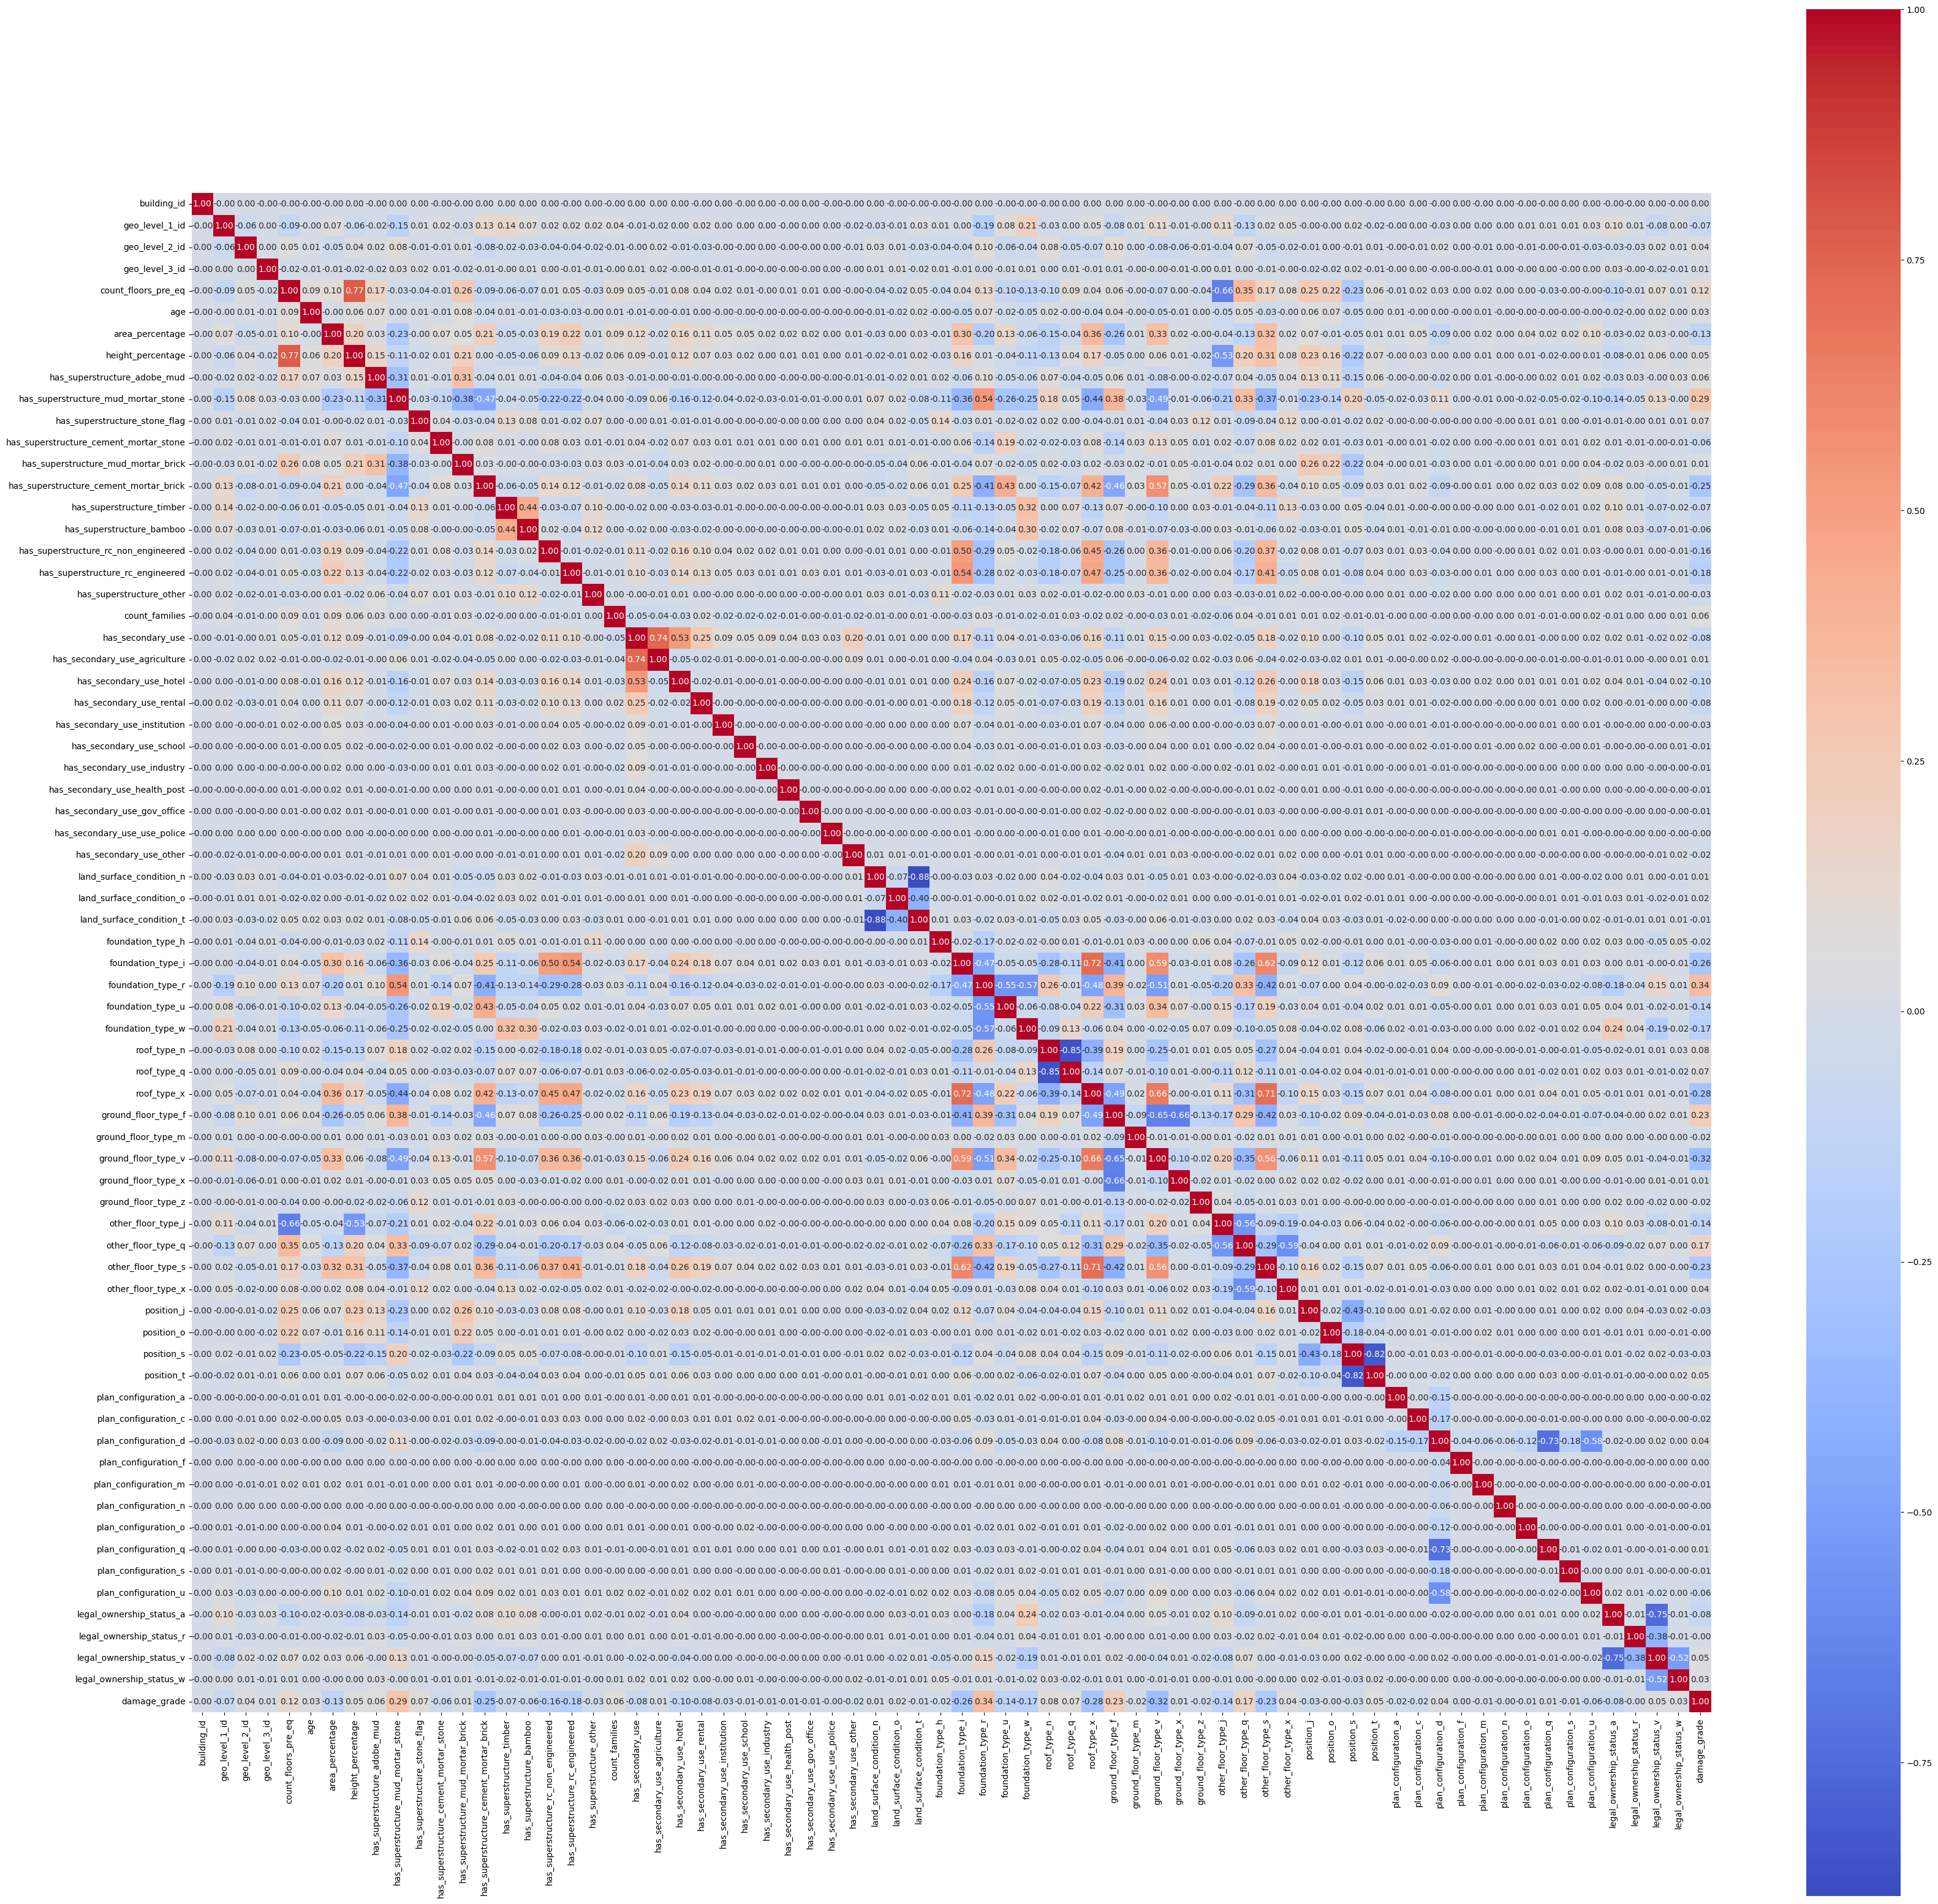

In [11]:
corr_matrix = train_data_one_hot_encoded.corr()
correlations_with_target = corr_matrix["damage_grade"]
correlations_with_target.to_csv("./data_analysis/correlations_with_target.csv")
plt.figure(figsize=(40, 40))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.show()

In [12]:
# Keep the columns having absolute correlation with target more than 0.1
feature_engineered_train_data = train_data_one_hot_encoded[
    correlations_with_target[abs(correlations_with_target) > 0.1].index
]
feature_engineered_test_data = test_data_one_hot_encoded[
    feature_engineered_train_data.columns[:-1]
]

corr_matrix = feature_engineered_train_data.corr()
correlations_with_target = corr_matrix["damage_grade"]

# If the correlation between two columns is more than 0.7, drop the column having less correlation with the target "damage_grade"
columns_to_drop = []
for column_i in corr_matrix.columns:
    for column_j in corr_matrix.columns:
        if column_i != column_j and abs(corr_matrix[column_i][column_j]) > 0.7:
            if abs(correlations_with_target[column_i]) < abs(
                correlations_with_target[column_j]
            ):
                if column_i not in columns_to_drop:
                    print(f"Dropping {column_i} because of {column_j}")
                    columns_to_drop.append(column_i)
            else:
                if column_j not in columns_to_drop:
                    print(f"Dropping {column_j} because of {column_i}")
                    columns_to_drop.append(column_j)

# Drop the columns
feature_engineered_train_data = feature_engineered_train_data.drop(
    columns_to_drop, axis=1
)
# Make sure the columns of test_data are same as train_data
feature_engineered_test_data = feature_engineered_test_data.drop(
    columns_to_drop, axis=1
)

# Assert test_values_encoded has the columns of train_data except "damage_grade"
assert set(feature_engineered_test_data.columns).union({"damage_grade"}) == set(
    feature_engineered_train_data.columns
) and len(feature_engineered_test_data.columns) + 1 == len(
    feature_engineered_train_data.columns
)

Dropping foundation_type_i because of roof_type_x
Dropping other_floor_type_s because of roof_type_x


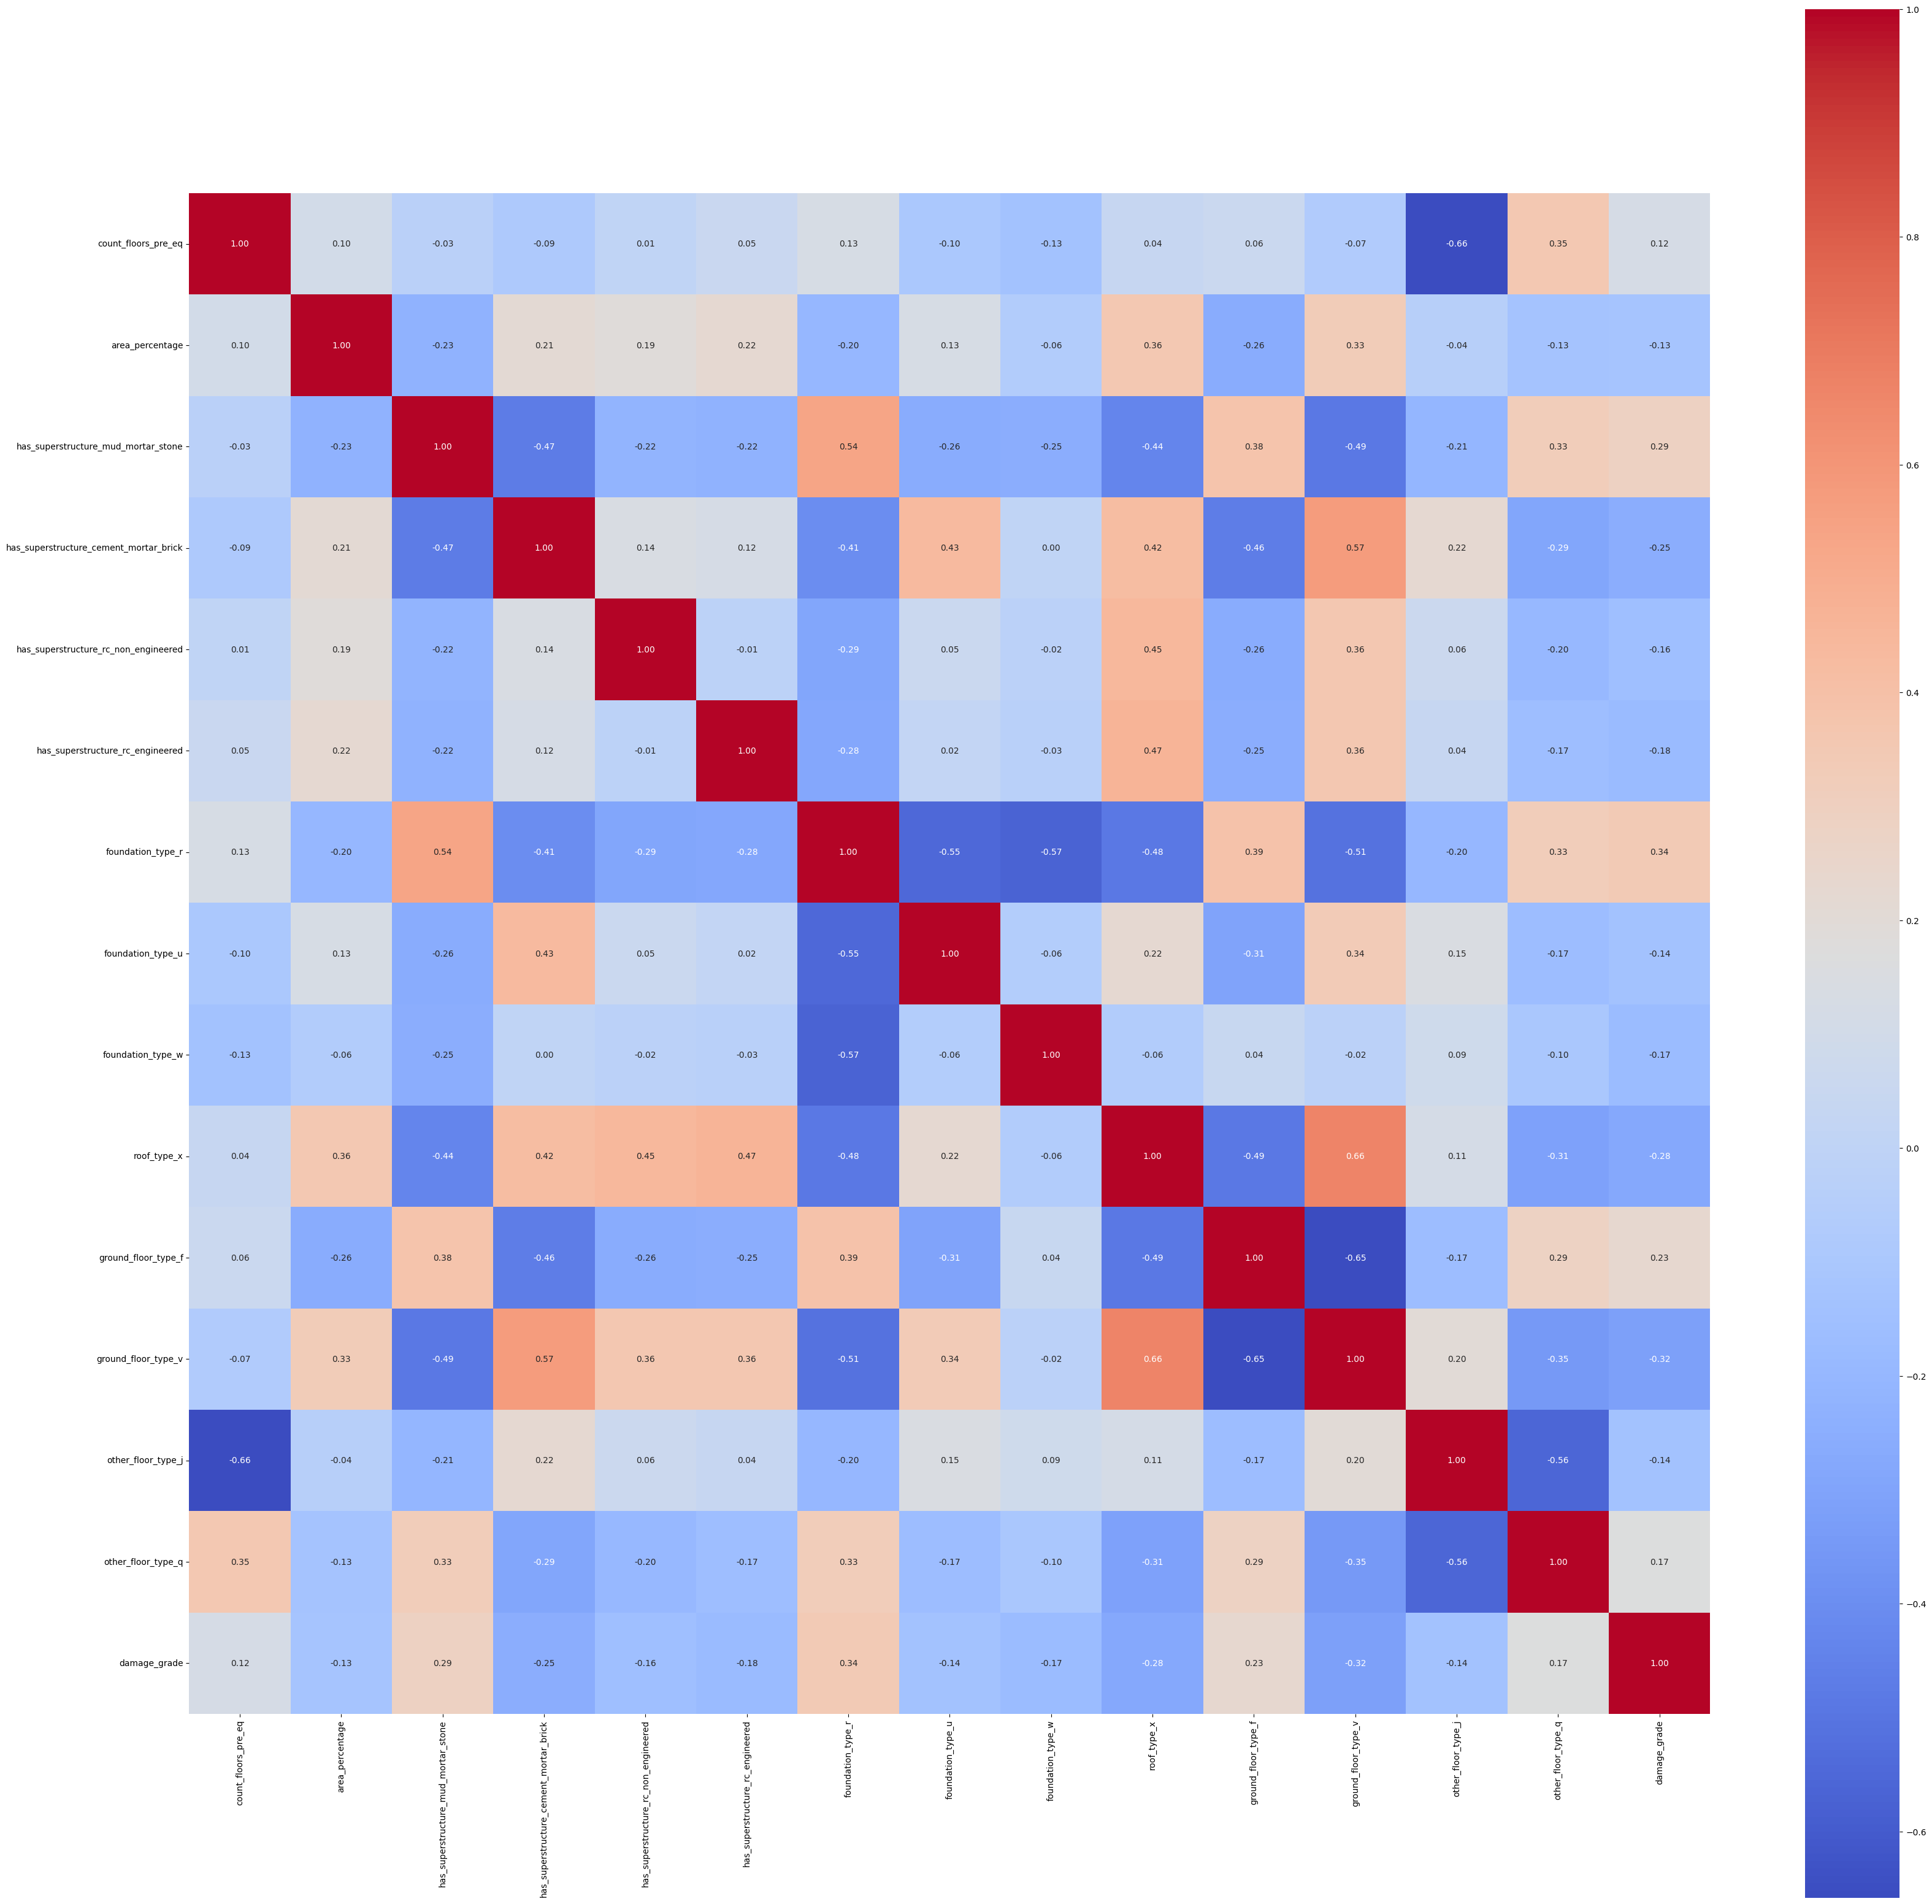

In [13]:
corr_matrix = feature_engineered_train_data.corr()
corr_matrix.to_csv("./data_analysis/feture_engineered_corr_matrix.csv")
plt.figure(figsize=(40, 40))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.show()

## PCA

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [15]:
scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(
    feature_engineered_train_data.drop("damage_grade", axis=1)
)
scaled_test_data = scaler.transform(feature_engineered_test_data)

In [16]:
# Have number of components as maximum possible
n_components = scaled_train_data.shape[1]

pca = PCA(n_components=n_components)
pca_train_data = pca.fit_transform(scaled_train_data)
pca_test_data = pca.transform(scaled_test_data)

In [17]:
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio

array([0.32533765, 0.14021286, 0.09973685, 0.08144441, 0.0720636 ,
       0.05514415, 0.05175425, 0.04367998, 0.03574967, 0.03071915,
       0.0214031 , 0.0192517 , 0.01850463, 0.00499797])

In [18]:
# The commulative sum of explained variance ratio, shows 7 components explain 82.46% of the variance
np.cumsum(explained_variance_ratio)

array([0.32533765, 0.46555052, 0.56528737, 0.64673178, 0.71879538,
       0.77393953, 0.82569378, 0.86937377, 0.90512343, 0.93584259,
       0.95724569, 0.97649739, 0.99500203, 1.        ])

In [19]:
n_components = 7

pca = PCA(n_components=n_components)
pca_train_data = pca.fit_transform(scaled_train_data)
pca_test_data = pca.transform(scaled_test_data)

## Handling outliers

In [20]:
# # Calculate Q1 and Q3 for each feature
# Q1 = np.quantile(pca_train_data, 0.25, axis=0)
# Q3 = np.quantile(pca_train_data, 0.75, axis=0)

# # Calculate the IQR
# IQR = Q3 - Q1

# # Define the outlier thresholds
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Remove the outliers
# no_outliers_train_data = pca_train_data[~((pca_train_data < lower_bound) | (pca_train_data > upper_bound)).any(axis=1)]
# print(f"Shape of no_outliers_train_data: {no_outliers_train_data.shape}")

# # Replace outliers in pca_test_data with the median
# medians = np.median(pca_train_data, axis=0)
# pca_test_data_df = pd.DataFrame(pca_test_data)
# replaced_outliers_test_data = pca_test_data_df.mask((pca_test_data_df < lower_bound) | (pca_test_data_df > upper_bound), medians, axis=1)
# replaced_outliers_test_data_array = replaced_outliers_test_data.to_numpy()

# print(f"Length of train data before removing outliers: {len(pca_train_data)}")
# print(f"Length of train data after removing outliers: {len(no_outliers_train_data)}")

# print(f"Length of test data before removing outliers: {len(pca_test_data)}")
# print(f"Length of test data after removing outliers: {len(replaced_outliers_test_data_array)}")

## Split the data into train and validation sets

In [24]:
from sklearn.model_selection import train_test_split

# X is feature_engineered_train_data without "damage_grade"
X = feature_engineered_train_data.drop("damage_grade", axis=1)
y = feature_engineered_train_data["damage_grade"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Normalize data

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()

# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
# pca_test_data = scaler.transform(pca_test_data)

# Training

## GridSearchCV

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline

# Define the pipelines for each classifier
# pipelines = {
#     "logistic_regression": Pipeline(
#         [
#             ("scaler", StandardScaler()),
#             ("classifier", LogisticRegression(solver="liblinear", random_state=42)),
#         ]
#     ),
#     "decision_tree": Pipeline(
#         [
#             ("scaler", StandardScaler()),
#             ("classifier", DecisionTreeClassifier(random_state=42)),
#         ]
#     ),
#     "random_forest": Pipeline(
#         [
#             ("scaler", StandardScaler()),
#             ("classifier", RandomForestClassifier(random_state=42)),
#         ]
#     ),
#     "xgboost": Pipeline(
#         [
#             ("scaler", StandardScaler()),
#             ("classifier", XGBClassifier(random_state=42, objective="multi:softmax")),
#         ]
#     ),
#     "lightgbm": Pipeline(
#         [
#             ("scaler", StandardScaler()),
#             ("classifier", LGBMClassifier(random_state=42, objective="multiclass")),
#         ]
#     ),
#     "svm": Pipeline(
#         [
#             ("scaler", StandardScaler()),
#             ("classifier", SVC(random_state=42, decision_function_shape="ovr")),
#         ]
#     ),
# }

hyperparameters = {
    "logistic_regression": {
        "classifier__C": [0.01, 0.1, 1],
        "classifier__penalty": ["l1", "l2"],
    },
    "decision_tree": {
        "classifier__max_depth": [5, 10],
        "classifier__min_samples_split": [2, 5],
        "classifier__min_samples_leaf": [2, 5],
    },
    "xgboost": {
        "classifier__learning_rate": [0.1],
        "classifier__max_depth": [5],
        "classifier__n_estimators": [100],
        "classifier__subsample": [0.8],
        "classifier__colsample_bytree": [0.8],
        "classifier__min_child_weight": [1],
    },
}

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
import numpy as np
from tqdm.auto import tqdm


# Define the hyperparameter search space for each model
# hyperparameters = {
#     'logreg': {'classifier__C': np.logspace(-3, 3, 7)},
#     'svm': {'classifier__C': [0.1, 1, 10], 'classifier__kernel': ['linear', 'rbf']},
#     'dtree': {'classifier__max_depth': [None, 10, 20, 30], 'classifier__min_samples_split': [2, 4, 8]},
#     'rf': {'classifier__n_estimators': [100, 200], 'classifier__max_depth': [None, 10, 20]},
#     'xgb': {'classifier__n_estimators': [100, 200], 'classifier__learning_rate': [0.1, 0.3], 'classifier__max_depth': [3, 6]},
#     'lgbm': {'classifier__n_estimators': [100, 200], 'classifier__learning_rate': [0.1, 0.3], 'classifier__max_depth': [3, 6]}
# }
# hyperparameters = {
#     "logistic_regression": {
#         "classifier__C": [0.001, 0.01, 0.1, 1, 10, 100],
#         "classifier__penalty": ["l1", "l2"],
#     },
#     "decision_tree": {
#         "classifier__max_depth": [3, 5, 10, 20, None],
#         "classifier__min_samples_leaf": [1, 2, 5, 10],
#         "classifier__min_samples_split": [2, 5, 10, 20],
#     },
#     "random_forest": {
#         "classifier__n_estimators": [10, 50, 100, 200],
#         "classifier__max_depth": [3, 5, 10, 20, None],
#         "classifier__min_samples_leaf": [1, 2, 5, 10],
#         "classifier__min_samples_split": [2, 5, 10, 20],
#     },
#     "xgboost": {
#         "classifier__learning_rate": [0.01, 0.1, 0.2],
#         "classifier__n_estimators": [50, 100, 200],
#         "classifier__max_depth": [3, 5, 10, 20],
#         "classifier__subsample": [0.5, 0.7, 1.0],
#         "classifier__colsample_bytree": [0.5, 0.7, 1.0],
#         "classifier__reg_lambda": [0.1, 1.0, 5.0],
#     },
#     "lightgbm": {
#         "classifier__learning_rate": [0.01, 0.1, 0.2],
#         "classifier__n_estimators": [50, 100, 200],
#         "classifier__max_depth": [3, 5, 10, 20],
#         "classifier__subsample": [0.5, 0.7, 1.0],
#         "classifier__colsample_bytree": [0.5, 0.7, 1.0],
#         "classifier__reg_lambda": [0.1, 1.0, 5.0],
#     },
#     "svm": {
#         "classifier__C": [0.001, 0.01, 0.1, 1, 10],
#         "classifier__kernel": ["linear", "rbf"],
#         "classifier__gamma": ["scale", "auto"],
#     },
# }
pipelines = {
    "logistic_regression": Pipeline(
        [
            ("scaler", StandardScaler()),
            ("classifier", LogisticRegression(solver="liblinear", random_state=42)),
        ]
    ),
    "decision_tree": Pipeline(
        [
            ("scaler", StandardScaler()),
            ("classifier", DecisionTreeClassifier(random_state=42)),
        ]
    ),
    "xgboost": Pipeline(
        [
            ("scaler", StandardScaler()),
            ("classifier", XGBClassifier(random_state=42, objective="multi:softmax")),
        ]
    ),
}

# Modify the labels for XGBoost
train_labels_xgboost = y_train - 1

# Perform a Grid Search or Randomized Search cross-validation for each model
f1_micro_scorer = make_scorer(f1_score, average="micro")
best_models = {}
best_estimators = {}
cv_results = {}

for name, pipeline in tqdm(pipelines.items(), desc="Grid searching", ncols=100):
    model = GridSearchCV(
        pipeline, hyperparameters[name], cv=5, scoring="f1_micro", verbose=1, n_jobs=-1
    )
    if name == "xgboost":
        model.fit(X_train, train_labels_xgboost)
    else:
        model.fit(X_train, y_train)
    best_models[name] = model
    best_estimators[name] = model.best_estimator_
    cv_results[name] = model.cv_results_
    print(f"Best parameters for {name}: {model.best_params_}")
    print(f"Best score for {name}: {model.best_score_}")

# Compare the results and choose the best model
for model_name, results in cv_results.items():
    print(f"{model_name}: {results['mean_test_score'].max()}")

# For example, choose the model with the highest mean test score
best_model_name = max(cv_results, key=lambda x: cv_results[x]["mean_test_score"].max())
best_model = best_estimators[best_model_name]
print(f"Best model: {best_model_name}")

## Train LightGBM

In [21]:
X = train_data_raw.drop(columns=["building_id", "damage_grade"])
y = train_data_raw["damage_grade"]

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
import lightgbm as lgb

params = {
    "objective": "multiclass",
    "num_class": 4,  # number of classes + 1 (to account for 0 index)
    "metric": "multi_logloss",
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "max_depth": -1,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": 0,
    "seed": 42,
}

# Create a LightGBM dataset
train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical_columns
)

# Train the model
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[
        train_data,
        lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_columns),
    ],
    early_stopping_rounds=50,
    verbose_eval=10,
)

/Users/parsahejabi/Codebases/GitHub_Repositories/USC-CSCI567-MachineLearning/venv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/parsahejabi/Codebases/GitHub_Repositories/USC-CSCI567-MachineLearning/venv/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/parsahejabi/Codebases/GitHub_Repositories/USC-CSCI567-MachineLearning/venv/lib/python3.11/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 50 rounds


/Users/parsahejabi/Codebases/GitHub_Repositories/USC-CSCI567-MachineLearning/venv/lib/python3.11/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/parsahejabi/Codebases/GitHub_Repositories/USC-CSCI567-MachineLearning/venv/lib/python3.11/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[10]	training's multi_logloss: 0.775754	valid_1's multi_logloss: 0.780408
[20]	training's multi_logloss: 0.72665	valid_1's multi_logloss: 0.730894
[30]	training's multi_logloss: 0.700312	valid_1's multi_logloss: 0.704469
[40]	training's multi_logloss: 0.686018	valid_1's multi_logloss: 0.690394
[50]	training's multi_logloss: 0.676822	valid_1's multi_logloss: 0.681719
[60]	training's multi_logloss: 0.669581	valid_1's multi_logloss: 0.675155
[70]	training's multi_logloss: 0.663123	valid_1's multi_logloss: 0.669333
[80]	training's multi_logloss: 0.658474	valid_1's multi_logloss: 0.665345
[90]	training's multi_logloss: 0.653931	valid_1's multi_logloss: 0.661468
[100]	training's multi_logloss: 0.649727	valid_1's multi_logloss: 0.657941
[110]	training's multi_logloss: 0.645885	valid_1's multi_logloss: 0.654738
[120]	training's multi_logloss: 0.642623	valid_1's multi_logloss: 0.652196
[130]	training's multi_logloss: 0.639341	valid_1's multi_logloss: 0.649424
[140]	training's multi_logloss: 0.6

### Tune hyperparameters of LightGBM

In [21]:
import optuna
import lightgbm as lgb
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split


def objective(trial):
    params = {
        "objective": "multiclass",
        "num_class": 3,
        "metric": "multi_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-8, 1.0),
    }

    X_train, X_val, y_train, y_val = train_test_split(
        train_data_raw.drop(columns=["building_id", "damage_grade"]),
        train_data_raw["damage_grade"],
        test_size=0.2,
        random_state=42,
    )
    dtrain = lgb.Dataset(X_train, label=y_train - 1)
    dval = lgb.Dataset(X_val, label=y_val - 1)

    gbm = lgb.train(
        params,
        dtrain,
        valid_sets=[dtrain, dval],
        verbose_eval=False,
        early_stopping_rounds=100,
    )
    preds = gbm.predict(X_val, num_iteration=gbm.best_iteration)
    log_loss_value = log_loss(y_val - 1, preds)

    return log_loss_value


study = optuna.create_study(direction="minimize")
study.optimize(
    objective, n_trials=100
)  # You can increase the number of trials for a more thorough search

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-04-21 18:34:23,795] A new study created in memory with name: no-name-cbd23351-790b-42ae-ac4d-031d75b67e4b
/var/folders/vy/c1wn5w9140vc300v9hk79clw0000gn/T/ipykernel_21315/374201393.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
/var/folders/vy/c1wn5w9140vc300v9hk79clw0000gn/T/ipykernel_21315/374201393.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
/var/folders/vy/c1wn5w9140vc300v9hk79clw0000gn/T/ipykernel_21315/374201393.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This featu

Best trial:
  Value:  0.5791108306808735
  Params: 
    lambda_l1: 1.541344937019501
    lambda_l2: 0.007138327736826277
    num_leaves: 241
    feature_fraction: 0.5301962628816208
    bagging_fraction: 0.7787488688913959
    bagging_freq: 4
    min_child_samples: 33
    learning_rate: 0.20933426580576445


In [23]:
trial.params

{'lambda_l1': 1.541344937019501,
 'lambda_l2': 0.007138327736826277,
 'num_leaves': 241,
 'feature_fraction': 0.5301962628816208,
 'bagging_fraction': 0.7787488688913959,
 'bagging_freq': 4,
 'min_child_samples': 33,
 'learning_rate': 0.20933426580576445,
 'objective': 'multiclass',
 'num_class': 3,
 'metric': 'multi_logloss',
 'verbosity': -1,
 'boosting_type': 'gbdt'}

In [22]:
import lightgbm as lgb

best_params = {
    "lambda_l1": 1.541344937019501,
    "lambda_l2": 0.007138327736826277,
    "num_leaves": 241,
    "feature_fraction": 0.5301962628816208,
    "bagging_fraction": 0.7787488688913959,
    "bagging_freq": 4,
    "min_child_samples": 33,
    "learning_rate": 0.20933426580576445,
    "objective": "multiclass",
    "num_class": 3,
    "metric": "multi_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
}
best_params["objective"] = "multiclass"
best_params["num_class"] = 3
best_params["metric"] = "multi_logloss"
best_params["verbosity"] = -1
best_params["boosting_type"] = "gbdt"

X_train = train_data_raw.drop(columns=["building_id", "damage_grade"])
y_train = train_data_raw["damage_grade"]
dtrain = lgb.Dataset(
    X_train, label=y_train - 1, categorical_feature=categorical_columns
)

gbm = lgb.train(
    best_params,
    dtrain,
    num_boost_round=1000,
)

# Make predictions on the test dataset
test_preds = gbm.predict(test_data_raw.drop(columns=["building_id"]))

/Users/parsahejabi/Codebases/GitHub_Repositories/USC-CSCI567-MachineLearning/venv/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


## Train XGBoost

### Train XGBoost on feature engineered data (without PCA)

In [94]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

train_data, valid_data, train_labels, valid_labels = train_test_split(
    feature_engineered_train_data.drop(columns=["damage_grade"]),
    feature_engineered_train_data["damage_grade"] - 1,
    test_size=0.2,
    random_state=42,
)

dtrain = xgb.DMatrix(train_data, label=train_labels)
dvalid = xgb.DMatrix(valid_data, label=valid_labels)

params = {
    "objective": "multi:softmax",
    "num_class": 3,
    "eval_metric": "mlogloss",
    "seed": 42,
}

evals = [(dtrain, "train"), (dvalid, "valid")]
num_round = 1000

bst = xgb.train(params, dtrain, num_round, evals, early_stopping_rounds=10)

valid_preds = bst.predict(dvalid)
valid_score = f1_score(valid_labels, valid_preds, average="micro")
print("Validation Micro F1 Score (Feature Engineered Data):", valid_score)

[0]	train-mlogloss:1.00580	valid-mlogloss:1.00638
[1]	train-mlogloss:0.94658	valid-mlogloss:0.94768


/Users/parsahejabi/Codebases/GitHub_Repositories/USC-CSCI567-MachineLearning/venv/lib/python3.11/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[2]	train-mlogloss:0.90680	valid-mlogloss:0.90826
[3]	train-mlogloss:0.87907	valid-mlogloss:0.88087
[4]	train-mlogloss:0.85927	valid-mlogloss:0.86137
[5]	train-mlogloss:0.84482	valid-mlogloss:0.84723
[6]	train-mlogloss:0.83411	valid-mlogloss:0.83681
[7]	train-mlogloss:0.82603	valid-mlogloss:0.82900
[8]	train-mlogloss:0.81989	valid-mlogloss:0.82310
[9]	train-mlogloss:0.81527	valid-mlogloss:0.81875
[10]	train-mlogloss:0.81168	valid-mlogloss:0.81530
[11]	train-mlogloss:0.80885	valid-mlogloss:0.81269
[12]	train-mlogloss:0.80670	valid-mlogloss:0.81074
[13]	train-mlogloss:0.80507	valid-mlogloss:0.80924
[14]	train-mlogloss:0.80368	valid-mlogloss:0.80809
[15]	train-mlogloss:0.80265	valid-mlogloss:0.80723
[16]	train-mlogloss:0.80184	valid-mlogloss:0.80660
[17]	train-mlogloss:0.80117	valid-mlogloss:0.80606
[18]	train-mlogloss:0.80057	valid-mlogloss:0.80563
[19]	train-mlogloss:0.80014	valid-mlogloss:0.80541
[20]	train-mlogloss:0.79976	valid-mlogloss:0.80519
[21]	train-mlogloss:0.79940	valid-mlogl

### Train XGBoost on feature engineered + PCA data

In [95]:
train_data_pca, valid_data_pca, train_labels, valid_labels = train_test_split(
    pca_train_data,
    feature_engineered_train_data["damage_grade"] - 1,
    test_size=0.2,
    random_state=42,
)

dtrain_pca = xgb.DMatrix(train_data_pca, label=train_labels)
dvalid_pca = xgb.DMatrix(valid_data_pca, label=valid_labels)

evals_pca = [(dtrain_pca, "train_pca"), (dvalid_pca, "valid_pca")]

bst_pca = xgb.train(params, dtrain_pca, num_round, evals_pca, early_stopping_rounds=10)

valid_preds_pca = bst_pca.predict(dvalid_pca)
valid_score_pca = f1_score(valid_labels, valid_preds_pca, average="micro")
print("Validation Micro F1 Score (Feature Engineered Data + PCA):", valid_score_pca)

[0]	train_pca-mlogloss:1.00559	valid_pca-mlogloss:1.00638


/Users/parsahejabi/Codebases/GitHub_Repositories/USC-CSCI567-MachineLearning/venv/lib/python3.11/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[1]	train_pca-mlogloss:0.94593	valid_pca-mlogloss:0.94750
[2]	train_pca-mlogloss:0.90573	valid_pca-mlogloss:0.90779
[3]	train_pca-mlogloss:0.87770	valid_pca-mlogloss:0.88023
[4]	train_pca-mlogloss:0.85763	valid_pca-mlogloss:0.86066
[5]	train_pca-mlogloss:0.84299	valid_pca-mlogloss:0.84651
[6]	train_pca-mlogloss:0.83215	valid_pca-mlogloss:0.83622
[7]	train_pca-mlogloss:0.82398	valid_pca-mlogloss:0.82848
[8]	train_pca-mlogloss:0.81774	valid_pca-mlogloss:0.82256
[9]	train_pca-mlogloss:0.81293	valid_pca-mlogloss:0.81810
[10]	train_pca-mlogloss:0.80915	valid_pca-mlogloss:0.81473
[11]	train_pca-mlogloss:0.80627	valid_pca-mlogloss:0.81225
[12]	train_pca-mlogloss:0.80398	valid_pca-mlogloss:0.81036
[13]	train_pca-mlogloss:0.80221	valid_pca-mlogloss:0.80890
[14]	train_pca-mlogloss:0.80077	valid_pca-mlogloss:0.80775
[15]	train_pca-mlogloss:0.79962	valid_pca-mlogloss:0.80690
[16]	train_pca-mlogloss:0.79864	valid_pca-mlogloss:0.80624
[17]	train_pca-mlogloss:0.79789	valid_pca-mlogloss:0.80576
[18]	t

#### Tune hyperparameters of XGBoost on feature engineered data

In [99]:
import optuna
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import xgboost as xgb


def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(
        feature_engineered_train_data.drop(columns=["damage_grade"]),
        feature_engineered_train_data["damage_grade"] - 1,
        test_size=0.2,
        random_state=42,
    )

    params = {
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
        "num_class": 3,
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 1.0),
        "lambda": trial.suggest_float("lambda", 1e-4, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-4, 1.0, log=True),
    }

    model = xgb.XGBClassifier(**params)
    model.fit(train_x, train_y)

    y_pred = model.predict(valid_x)
    f1_micro = f1_score(valid_y, y_pred, average="micro")

    return f1_micro


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2023-04-21 20:33:07,457] A new study created in memory with name: no-name-05a824d7-6c97-488e-bd3d-0b31d71658da
[I 2023-04-21 20:34:12,294] Trial 0 finished with value: 0.5796703823794632 and parameters: {'n_estimators': 494, 'max_depth': 9, 'learning_rate': 0.0007493617530605716, 'min_child_weight': 5, 'subsample': 0.8478953624308416, 'colsample_bytree': 0.7317594786237871, 'gamma': 0.9911579510464475, 'lambda': 0.2029500316014963, 'alpha': 0.08746976621498459}. Best is trial 0 with value: 0.5796703823794632.
[I 2023-04-21 20:34:22,279] Trial 1 finished with value: 0.5707104621937414 and parameters: {'n_estimators': 359, 'max_depth': 2, 'learning_rate': 0.00016144118992071797, 'min_child_weight': 6, 'subsample': 0.8996852477346848, 'colsample_bytree': 0.5734938190655591, 'gamma': 0.7259684957483106, 'lambda': 0.0007622411405635272, 'alpha': 0.0830030549673316}. Best is trial 0 with value: 0.5796703823794632.
[I 2023-04-21 20:34:29,886] Trial 2 finished with value: 0.5822221369505574

KeyboardInterrupt: 

In [100]:
best_trial = study.best_trial
print(f"Best trial (up to trial {len(study.trials)}):")
print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

Best trial (up to trial 65):
  Value: 0.5868268068532837
  Params: 
    n_estimators: 422
    max_depth: 9
    learning_rate: 0.013470528019190223
    min_child_weight: 10
    subsample: 0.7593422352942947
    colsample_bytree: 0.922855814033339
    gamma: 0.36792197181816627
    lambda: 0.1995407565335028
    alpha: 0.6390265681798395


In [101]:
best_trial

FrozenTrial(number=51, state=1, values=[0.5868268068532837], datetime_start=datetime.datetime(2023, 4, 21, 21, 46, 25, 204735), datetime_complete=datetime.datetime(2023, 4, 21, 21, 47, 29, 301181), params={'n_estimators': 422, 'max_depth': 9, 'learning_rate': 0.013470528019190223, 'min_child_weight': 10, 'subsample': 0.7593422352942947, 'colsample_bytree': 0.922855814033339, 'gamma': 0.36792197181816627, 'lambda': 0.1995407565335028, 'alpha': 0.6390265681798395}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'max_depth': IntDistribution(high=10, log=False, low=2, step=1), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.0001, step=None), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistrib

In [23]:
import xgboost as xgb

optimal_params = {
    "n_estimators": 422,
    "max_depth": 9,
    "learning_rate": 0.013470528019190223,
    "min_child_weight": 10,
    "subsample": 0.7593422352942947,
    "colsample_bytree": 0.922855814033339,
    "gamma": 0.36792197181816627,
    "lambda": 0.1995407565335028,
    "alpha": 0.6390265681798395,
    "objective": "multi:softprob",
    "num_class": 3,
    "n_jobs": -1,
    "random_state": 42,
}

# Create and train the XGBoost classifier with the optimal hyperparameters
final_clf = xgb.XGBClassifier(**optimal_params)
final_clf.fit(
    feature_engineered_train_data.drop(columns=["damage_grade"]),
    feature_engineered_train_data["damage_grade"] - 1,
)

# Make predictions on the test set
y_pred = final_clf.predict(feature_engineered_test_data)

## Ensemble of LightGBM and XGBoost

In [117]:
import numpy as np
from sklearn.metrics import f1_score

# Compute predicted probabilities for both models
lgbm_probs = gbm.predict(test_data_raw.drop(columns=["building_id"]))
xgb_probs = final_clf.predict_proba(feature_engineered_test_data)

# Average the predicted probabilities
avg_probs = (lgbm_probs + xgb_probs) / 2

# Choose the class with the highest probability as the final prediction
ensemble_preds = np.argmax(avg_probs, axis=1)

(86868,)
[2 1 1 ... 1 1 1]


In [122]:
y_preds_classes = ensemble_preds + 1

submission = pd.DataFrame(
    {"building_id": test_data_raw["building_id"], "damage_grade": y_preds_classes}
)

submission.to_csv("submission_xgb_lgbm.csv", index=False)

## Ensemble of LightGBM and XGBoost and CatBoost

In [24]:
# Read catboost_submission.csv
catboost_submission = pd.read_csv("catboost_submission.csv")

lgbm_probs = gbm.predict(test_data_raw.drop(columns=["building_id"]))
xgb_probs = final_clf.predict_proba(feature_engineered_test_data)

# Get the argmax of the predicted probabilities
lgbm_preds = np.argmax(lgbm_probs, axis=1) + 1
xgb_preds = np.argmax(xgb_probs, axis=1) + 1
catboost_preds = catboost_submission["damage_grade"]

# Get the majority vote of the predictions and if there is a tie, get the argmax of the average predicted probabilities
ensemble_preds = []
for i in range(len(lgbm_preds)):
    if lgbm_preds[i] == xgb_preds[i] or lgbm_preds[i] == catboost_preds[i]:
        ensemble_preds.append(lgbm_preds[i])
    elif xgb_preds[i] == catboost_preds[i]:
        ensemble_preds.append(xgb_preds[i])
    else:
        avg_probs = (lgbm_probs[i] + xgb_probs[i]) / 2
        ensemble_preds.append(np.argmax(avg_probs) + 1)

submission = pd.DataFrame(
    {"building_id": test_data_raw["building_id"], "damage_grade": ensemble_preds}
)

submission.to_csv("xgb+catboost+lgbm.csv", index=False)

## Encode geo

In [9]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

geo_columns = ["geo_level_1_id", "geo_level_2_id", "geo_level_3_id"]
encoder = OneHotEncoder()
train_test_data = pd.concat([train_data_raw, test_data_raw], axis=0)

geo_onehot = encoder.fit_transform(train_test_data[geo_columns]).toarray()

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print(
            "MPS not available because the current PyTorch install was not "
            "built with MPS enabled."
        )
    else:
        print(
            "MPS not available because the current MacOS version is not 12.3+ "
            "and/or you do not have an MPS-enabled device on this machine."
        )

else:
    device = torch.device("mps")

device

device(type='mps')

In [13]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dim, encoding_dim), nn.ReLU()).to(
            device
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim), nn.Sigmoid()
        ).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


input_dim = geo_onehot.shape[1]
encoding_dim = 16  # You can choose a different value based on your requirements

autoencoder = Autoencoder(input_dim, encoding_dim)
autoencoder.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=13310, out_features=16, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=13310, bias=True)
    (1): Sigmoid()
  )
)

In [14]:
from torch.utils.data import DataLoader, TensorDataset

geo_onehot_tensor = torch.tensor(geo_onehot, dtype=torch.float32).to(device)
dataset = TensorDataset(geo_onehot_tensor, geo_onehot_tensor)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

criterion = nn.BCELoss()
optimizer = optim.Adam(autoencoder.parameters())

num_epochs = 10
for epoch in range(num_epochs):
    for data, target in dataloader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = autoencoder(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.8f}")

Epoch [1/10], Loss: 0.00315366
Epoch [2/10], Loss: 0.00076908
Epoch [3/10], Loss: 0.00019235
Epoch [4/10], Loss: 0.00010342
Epoch [5/10], Loss: 0.00014165
Epoch [6/10], Loss: 0.00012393
Epoch [7/10], Loss: 0.00006790
Epoch [8/10], Loss: 0.00009617
Epoch [9/10], Loss: 0.00003162
Epoch [10/10], Loss: 0.00015261


In [15]:
with torch.no_grad():
    geo_embeddings = (
        autoencoder.encoder(torch.tensor(geo_onehot, dtype=torch.float32).to(device))
        .cpu()
        .numpy()
    )

: 

: 

In [ ]:
geo_embeddings.shape

In [151]:
train_data_with_embeddings = pd.DataFrame(
    geo_embeddings, columns=[f"geo_embed_{i}" for i in range(geo_embeddings.shape[1])]
)
train_data_with_embeddings = pd.concat(
    [train_data_raw.reset_index(drop=True), train_data_with_embeddings], axis=1
)

train_data_with_embeddings

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,geo_embed_22,geo_embed_23,geo_embed_24,geo_embed_25,geo_embed_26,geo_embed_27,geo_embed_28,geo_embed_29,geo_embed_30,geo_embed_31
0,802906,6,487,12198,2,30,6,5,t,r,...,0.000000,0.000000,0.000000,0.000000,3.028565,3.023105,1.081650,0.018237,1.406377,0.916951
1,28830,8,900,2812,2,10,8,7,o,r,...,0.000000,1.966149,0.681316,0.928076,0.000000,0.952177,1.789304,0.000000,0.500975,0.261451
2,94947,21,363,8973,2,10,5,5,t,r,...,2.411796,0.000000,0.072249,0.000000,1.643679,0.000000,2.140810,0.000000,2.982146,0.000000
3,590882,22,418,10694,2,10,6,5,t,r,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.935883,0.560473,0.000000,0.000000,0.000000
4,201944,11,131,1488,3,30,8,9,t,r,...,0.000000,0.000000,0.986332,1.804192,0.862430,0.000000,0.000000,0.000000,2.337351,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,25,1335,1621,1,55,6,3,n,r,...,0.783885,0.998404,0.921398,0.933915,1.011943,0.995385,0.920436,1.045049,0.724807,1.787620
260597,669485,17,715,2060,2,0,6,5,t,r,...,0.783885,0.998404,0.921398,0.933915,1.011943,0.995385,0.920436,1.045049,0.724807,1.787620
260598,602512,17,51,8163,3,55,6,7,t,r,...,0.783885,0.998404,0.921398,0.933915,1.011943,0.995385,0.920436,1.045049,0.724807,1.787620
260599,151409,26,39,1851,2,10,14,6,t,r,...,0.783885,0.998404,0.921398,0.933915,1.011943,0.995385,0.920436,1.045049,0.724807,1.787620


In [152]:
import lightgbm as lgb

best_params = {
    "lambda_l1": 1.541344937019501,
    "lambda_l2": 0.007138327736826277,
    "num_leaves": 241,
    "feature_fraction": 0.5301962628816208,
    "bagging_fraction": 0.7787488688913959,
    "bagging_freq": 4,
    "min_child_samples": 33,
    "learning_rate": 0.20933426580576445,
    "objective": "multiclass",
    "num_class": 3,
    "metric": "multi_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
}
best_params["objective"] = "multiclass"
best_params["num_class"] = 3
best_params["metric"] = "multi_logloss"
best_params["verbosity"] = -1
best_params["boosting_type"] = "gbdt"

X_train = train_data_with_embeddings.drop(columns=["building_id", "damage_grade"])
y_train = train_data_with_embeddings["damage_grade"]
dtrain = lgb.Dataset(
    X_train, label=y_train - 1, categorical_feature=categorical_columns
)

gbm = lgb.train(
    best_params,
    dtrain,
    num_boost_round=1000,
)

# Make predictions on the test dataset
test_preds = gbm.predict(test_data_raw.drop(columns=["building_id"]))

/Users/parsahejabi/Codebases/GitHub_Repositories/USC-CSCI567-MachineLearning/venv/lib/python3.11/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
[LightGBM] [Fatal] The number of features in data (38) is not the same as it was in training data (70).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.


LightGBMError: The number of features in data (38) is not the same as it was in training data (70).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

# Submission

In [121]:
import numpy as np
import pandas as pd

# Get the class with the highest probability for each test instance
test_preds_classes = np.argmax(test_preds, axis=1) + 1

# Create a submission DataFrame
submission = pd.DataFrame(
    {"building_id": test_data_raw["building_id"], "damage_grade": test_preds_classes}
)

# Save the submission DataFrame to a CSV file
submission.to_csv("submission.csv", index=False)

AxisError: axis 1 is out of bounds for array of dimension 1